<a href="https://colab.research.google.com/github/ipediz/BachehayekhafaneTMU/blob/main/Doubly_Robout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Helper imports
! pip install econml
! pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
from sklearn.linear_model import LassoCV
from econml.dr import LinearDRLearner
from sklearn.dummy import DummyClassifier

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm



Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



In [ ]:
import pandas as pd

In [ ]:
Data = pd.read_csv(r'All_STATE_CASUAL_READY_2.csv')

In [ ]:
Data['Treatment'] = Data['Treatment'].replace({1: True, 0: False})

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [ ]:
from tabulate import tabulate
#dropping non-relative variables for summary statistics table
columns_to_drop = [
    'relative_time_m8andbeyond', 'relative_time_m7', 'relative_time_m6', 'relative_time_m5',
    'relative_time_m4', 'relative_time_m3', 'relative_time_m2', 'relative_time_m1', 'relative_time_0',
    'relative_time_p1', 'relative_time_p2', 'relative_time_p3', 'relative_time_p4',
    'relative_time_p5', 'relative_time_p6', 'relative_time_p7', 'relative_time_p8andbeyond',
    'cem_strata', 'cem_weights', 'new_timeperiod','county_code', 'nonbusiness_bankruptcy_percapita','business_bankruptcy_percapita', 'log_bankruptcy'
]

# Create a new dataframe without the specified columns



# Create a new dataframe without the specified columns
Data1= Data.drop(columns=columns_to_drop)
Data1 = Data1.dropna();

In [ ]:
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier

# Define the adjusted model with best results for regression and propensity score
est = LinearDRLearner(
    model_regression=LGBMRegressor(n_estimators=500, max_depth=10),
    model_propensity=RandomForestClassifier(n_estimators=100, max_depth=5)
)

# Adjusted variables: X, T, and y from Data
y = Data1['bankruptcy_per_capita'].values
T = Data1['Treatment'].values
X = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force','employed_individuals',]].values

# Fit the model
est.fit(y, T, X=X)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.653180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.654085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# Get summary statistics to find realistic values for each variable
population_estimation_mean = Data1['population_estimation'].mean()
monthly_earnings_mean = Data1['monthly_earnings'].mean()
medianhouseholdincome_mean = Data1['medianhouseholdincome'].mean()
labor_force_mean = Data1['labor_force'].mean()
employed_individuals_mean = Data1['employed_individuals'].mean()

# Create a realistic segment with these means (or you can choose specific percentiles for a different profile)
segment = np.array([[population_estimation_mean, monthly_earnings_mean,
                     medianhouseholdincome_mean, labor_force_mean, employed_individuals_mean]])

# Estimate the treatment effect for this realistic segment
effect = est.effect(segment)
print("Estimated treatment effect for the realistic segment:", effect)


Estimated treatment effect for the realistic segment: [-0.0105692]


In [ ]:

# Calculate a 95% confidence interval for the estimated effect on this realistic segment
effect_conf_interval = est.effect_interval(segment, alpha=0.05)
print("95% Confidence Interval for the treatment effect on the realistic segment:", effect_conf_interval)


95% Confidence Interval for the treatment effect on the realistic segment: (array([-0.01589894]), array([-0.00523945]))


In [ ]:
effect_inference = est.effect_inference(segment).summary_frame(alpha=0.05)
print("Detailed inference for the treatment effect on the realistic segment:")
print(effect_inference)

Detailed inference for the treatment effect on the realistic segment:
   point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                           
0          -0.011   0.003 -3.887     0.0    -0.016    -0.005


In [ ]:
# Define feature names based on the adjusted `X` variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Print the coefficients with the corresponding feature names
print("Coefficients of the linear CATE model with feature names:")
print(np.array(list(zip(feature_names, est.coef_(T=1)))))

# Print the intercept of the model
print("Intercept of the linear CATE model:")
print(est.intercept_(T=1))


Coefficients of the linear CATE model with feature names:
[['population_estimation' '-3.453889547843118e-05']
 ['monthly_earnings' '-0.0024450766426092436']
 ['medianhouseholdincome' '0.0029816941757430447']
 ['labor_force' '8.284974059542878e-05']
 ['employed_individuals' '-0.00037446314961827']]
Intercept of the linear CATE model:
-0.1298496327748835


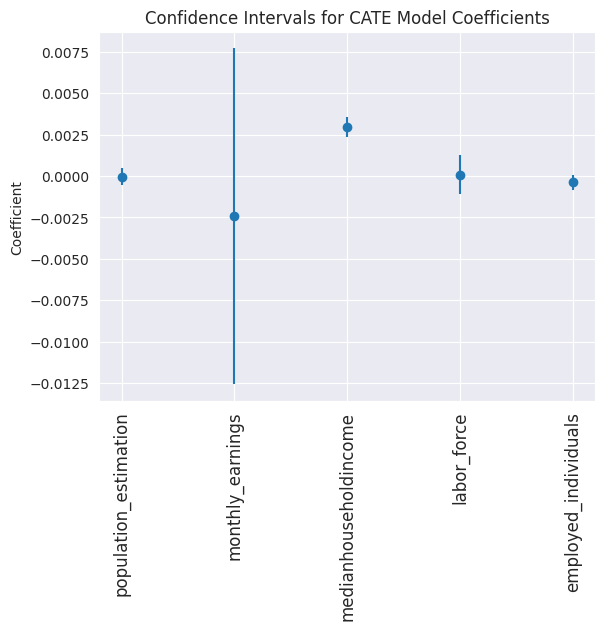

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names based on your adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Get the point estimates and confidence intervals for the coefficients of the CATE model
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

# Plot the coefficients with error bars representing the confidence intervals
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation='vertical', fontsize=12)
    ax.set_ylabel('Coefficient')
    ax.set_title('Confidence Intervals for CATE Model Coefficients')
    plt.show()


In [ ]:
# Define feature names based on your adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Get the detailed inference for the coefficients with the corresponding feature names
coef_inference = est.coef__inference(T=1).summary_frame(feature_names=feature_names)

print("Detailed inference for the coefficients of the CATE model:")
print(coef_inference)


Detailed inference for the coefficients of the CATE model:
                       point_estimate  stderr  zstat  pvalue  ci_lower  \
X                                                                        
population_estimation          -0.000   0.000 -0.130   0.897    -0.001   
monthly_earnings               -0.002   0.005 -0.472   0.637    -0.013   
medianhouseholdincome           0.003   0.000  9.623   0.000     0.002   
labor_force                     0.000   0.001  0.135   0.892    -0.001   
employed_individuals           -0.000   0.000 -1.620   0.105    -0.001   

                       ci_upper  
X                                
population_estimation     0.000  
monthly_earnings          0.008  
medianhouseholdincome     0.004  
labor_force               0.001  
employed_individuals      0.000  


In [ ]:
est.intercept__inference(T=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,-0.13,0.015,-8.828,0.0,-0.159,-0.101


In [ ]:
eature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Get the summary of the CATE model with the specified feature names
model_summary = est.summary(T=1, feature_names=feature_names)

print("Summary of the CATE model:")
print(model_summary)

Summary of the CATE model:
                            Coefficient Results                            
                      point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------------------
population_estimation           -0.0    0.0  -0.13  0.897   -0.001      0.0
monthly_earnings              -0.002  0.005 -0.472  0.637   -0.013    0.008
medianhouseholdincome          0.003    0.0  9.623    0.0    0.002    0.004
labor_force                      0.0  0.001  0.135  0.892   -0.001    0.001
employed_individuals            -0.0    0.0  -1.62  0.105   -0.001      0.0
                       CATE Intercept Results                       
               point_estimate stderr zstat  pvalue ci_lower ci_upper
--------------------------------------------------------------------
cate_intercept          -0.13  0.015 -8.828    0.0   -0.159   -0.101
--------------------------------------------------------------------

<sub>A linear param

In [ ]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dr import LinearDRLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor

# Set up the model with the best-performing models for regression and propensity
est = LinearDRLearner(
    model_regression=LGBMRegressor(n_estimators=500, max_depth=10),
    model_propensity=RandomForestClassifier(n_estimators=100, max_depth=5),
    featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

# Fit the model using the adjusted variables
est.fit(y, T, X=X)

# Print a message to confirm the model has been fit
print("Model has been fitted with PolynomialFeatures as featurizer.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.653489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.653776
Model has been fitted with PolynomialFeatures as featurizer.


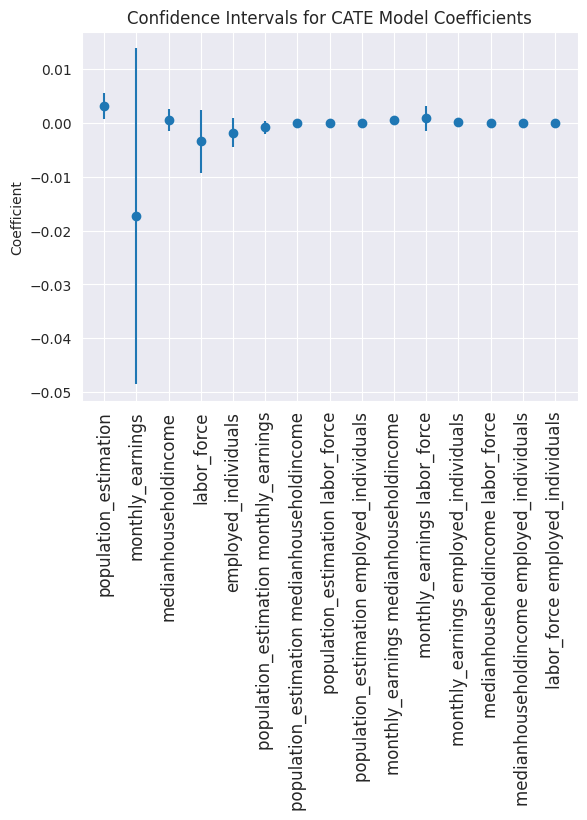

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve the actual feature names used by the CATE model after featurization
feature_names = est.cate_feature_names(feature_names=['population_estimation', 'monthly_earnings',
                                                      'medianhouseholdincome', 'labor_force', 'employed_individuals'])

# Get the point estimates and confidence intervals for the coefficients of the CATE model
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

# Plot the coefficients with error bars representing the confidence intervals
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation='vertical', fontsize=12)
    ax.set_ylabel('Coefficient')
    ax.set_title('Confidence Intervals for CATE Model Coefficients')
    plt.show()


In [ ]:
# Assuming you want to create X_test from Data1 as a sample of the main data
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Now get the inference of the CATE at different X vector values in X_test
effect_inference = est.effect_inference(X_test).summary_frame()

print("Inference of the CATE at different X vector values:")
print(effect_inference)


Inference of the CATE at different X vector values:
       point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                               
0              -0.016   0.005 -3.326   0.001    -0.026    -0.007
1              -0.017   0.005 -3.814   0.000    -0.026    -0.008
2              -0.017   0.005 -3.488   0.000    -0.026    -0.007
3              -0.018   0.004 -4.067   0.000    -0.026    -0.009
4              -0.016   0.005 -3.024   0.002    -0.027    -0.006
...               ...     ...    ...     ...       ...       ...
64423           0.009   0.004  2.230   0.026     0.001     0.017
64424           0.010   0.005  2.077   0.038     0.001     0.019
64425           0.018   0.005  3.753   0.000     0.008     0.027
64426           0.018   0.005  3.827   0.000     0.009     0.028
64427           0.017   0.005  3.718   0.000     0.008     0.027

[64428 rows x 6 columns]


In [ ]:
# Define X_test if it's not already defined, using all relevant features
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Get the population inference given the sample X_test
population_inference = est.effect_inference(X_test).population_summary()

print("Population inference given sample X:")
print(population_inference)


Population inference given sample X:
               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     -0.01       0.003 -3.641    0.0        -0.016        -0.005
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.034          -0.052           0.077
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.034         -0.057          0.078
------------------------------------------


In [ ]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dr import SparseLinearDRLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor

# Set up the model with the updated model choices and featurizer
est = SparseLinearDRLearner(
    model_regression=LGBMRegressor(n_estimators=500, max_depth=10),
    model_propensity=RandomForestClassifier(n_estimators=100, max_depth=5),
    featurizer=PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
)

# Fit the model using the adjusted variables
est.fit(y, T, X=X)

# Print a message to confirm the model has been fit
print("SparseLinearDRLearner model has been fitted with PolynomialFeatures (degree=3) as featurizer.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.650957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 32214, number of used features: 6
[LightGBM] [Info] Start training from score 0.656308


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+02, tolerance: 2.409e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.119e+00, tolerance: 2.586e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+01, tolerance: 2.586e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+01, tolerance: 2.586e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+01, tolerance: 2.586e+00
Objective did n

SparseLinearDRLearner model has been fitted with PolynomialFeatures (degree=3) as featurizer.


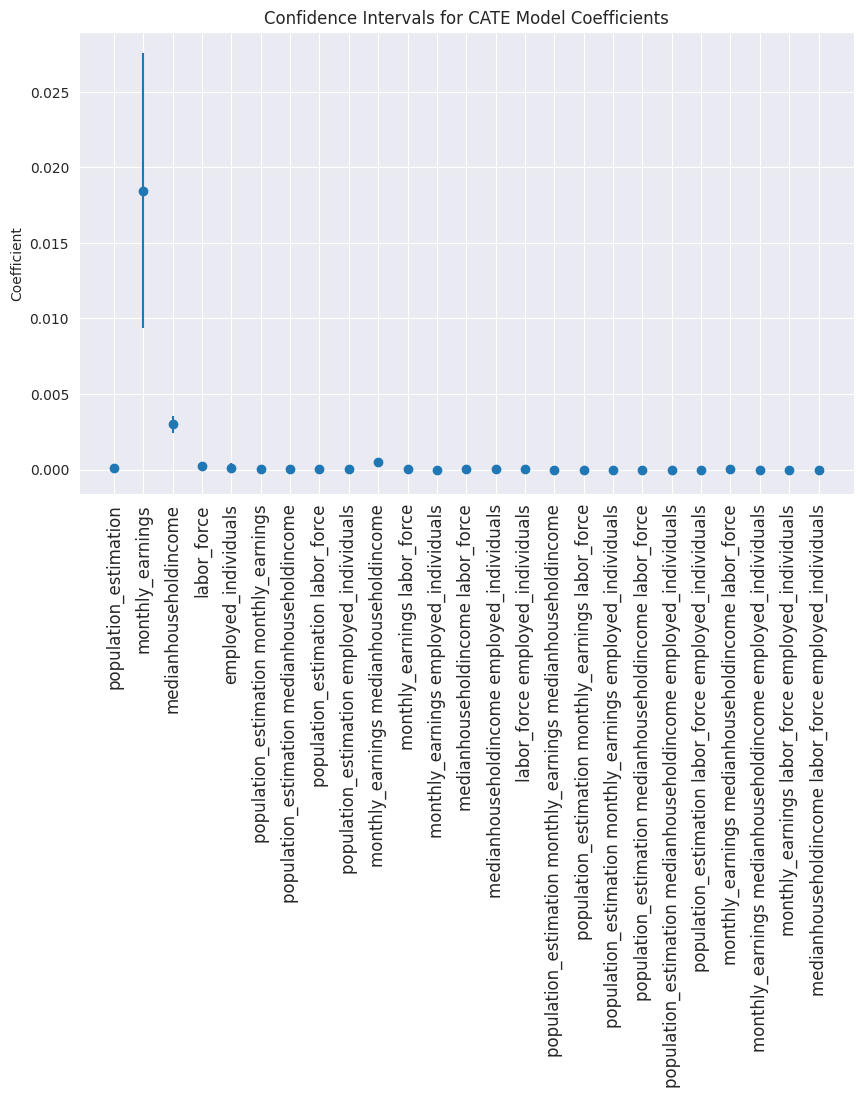

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve the actual feature names used by the CATE model after applying the featurizer
feature_names = est.cate_feature_names(['population_estimation', 'monthly_earnings',
                                        'medianhouseholdincome', 'labor_force', 'employed_individuals'])

# Get the point estimates and confidence intervals for the coefficients of the CATE model
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

# Plot the coefficients with error bars representing the confidence intervals
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation='vertical', fontsize=12)
    ax.set_ylabel('Coefficient')
    ax.set_title('Confidence Intervals for CATE Model Coefficients')
    plt.show()


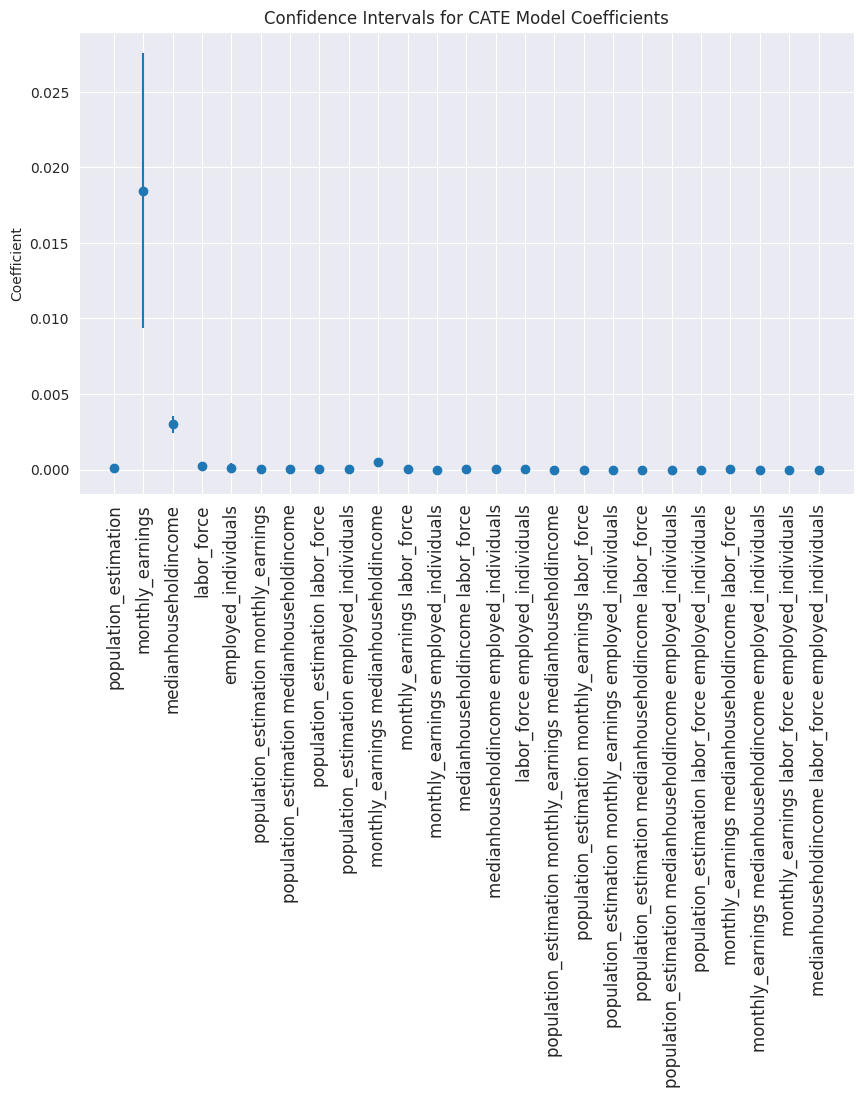

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names based on your actual adjusted X variables
feature_names = est.cate_feature_names(['population_estimation', 'monthly_earnings',
                                        'medianhouseholdincome', 'labor_force', 'employed_individuals'])

# Get the point estimates and confidence intervals for the coefficients of the CATE model
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

# Plot the coefficients with error bars representing the confidence intervals
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation='vertical', fontsize=12)
    ax.set_ylabel('Coefficient')
    ax.set_title('Confidence Intervals for CATE Model Coefficients')
    plt.show()


In [ ]:
# Define X_test if it's not already defined, using all relevant features
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Get the inference of the CATE at different X vector values in X_test
effect_inference = est.effect_inference(X_test).summary_frame()

print("Inference of the CATE at different X vector values:")
print(effect_inference)


Inference of the CATE at different X vector values:
       point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                               
0              -0.133   0.051 -2.613   0.009    -0.232    -0.033
1              -0.128   0.050 -2.553   0.011    -0.227    -0.030
2              -0.132   0.051 -2.597   0.009    -0.231    -0.032
3              -0.125   0.050 -2.496   0.013    -0.223    -0.027
4              -0.138   0.051 -2.689   0.007    -0.239    -0.038
...               ...     ...    ...     ...       ...       ...
64423          -0.022   0.038 -0.599   0.549    -0.096     0.051
64424          -0.004   0.036 -0.125   0.901    -0.075     0.066
64425          -0.004   0.037 -0.122   0.903    -0.077     0.068
64426           0.009   0.036  0.247   0.805    -0.061     0.079
64427           0.001   0.036  0.037   0.971    -0.069     0.072

[64428 rows x 6 columns]


In [ ]:
# Define X_test if it's not already defined, using all relevant features
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Get the population inference given the sample X_test
population_inference = est.effect_inference(X_test).population_summary()

print("Population inference given sample X:")
print(population_inference)


Population inference given sample X:
               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
    -0.011       0.003 -3.857    0.0        -0.016        -0.005
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.226          -0.186           0.706
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.226         -0.241          0.684
------------------------------------------


In [ ]:
from econml.dr import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

# Set up the model with optimized parameters for regression and propensity models
est = ForestDRLearner(
    model_regression=GradientBoostingRegressor(),
    model_propensity=RandomForestClassifier(n_estimators=100, max_depth=5),
    cv=5,
    n_estimators=1000,
    min_samples_leaf=10,  # Minimum of 10 samples in each leaf
    min_weight_fraction_leaf=0.01,  # Minimum 1% of the total weight of all samples
    verbose=0
)

# Fit the model using the full feature set without slicing X
est.fit(y, T, X=X)

# Print a message to confirm the model has been fit
print("ForestDRLearner model has been fitted with GradientBoostingRegressor and RandomForestClassifier.")


ForestDRLearner model has been fitted with GradientBoostingRegressor and RandomForestClassifier.


In [ ]:
# Define feature names based on your adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Get feature importances for the treatment group T=1
feature_importances = est.feature_importances_(T=1)

# Display feature importances along with feature names
print("Feature Importances for Treatment (T=1):")
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance}")


Feature Importances for Treatment (T=1):
population_estimation: 0.031152705687502846
monthly_earnings: 0.014829320808552376
medianhouseholdincome: 0.870516837006247
labor_force: 0.04887088984287911
employed_individuals: 0.03463024665481858


In [ ]:
# Print the structure of shap_values to understand available keys
print("SHAP Values Structure:", shap_values.keys())

# Then access the relevant part of shap_values based on the output structure


NameError: name 'shap_values' is not defined

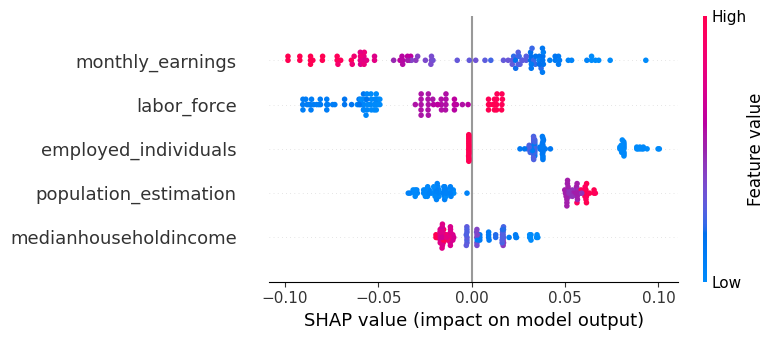

In [ ]:
import shap
from sklearn.ensemble import GradientBoostingRegressor

# Fit a separate instance of the GradientBoostingRegressor to model the outcome
model = GradientBoostingRegressor()
model.fit(X, y)

# Now use SHAP with TreeExplainer on this fitted model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:100])  # Adjust sample size as needed

# Define your feature names based on the adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Plot the summary of SHAP values
shap.summary_plot(shap_values, features=X[:100], feature_names=feature_names)


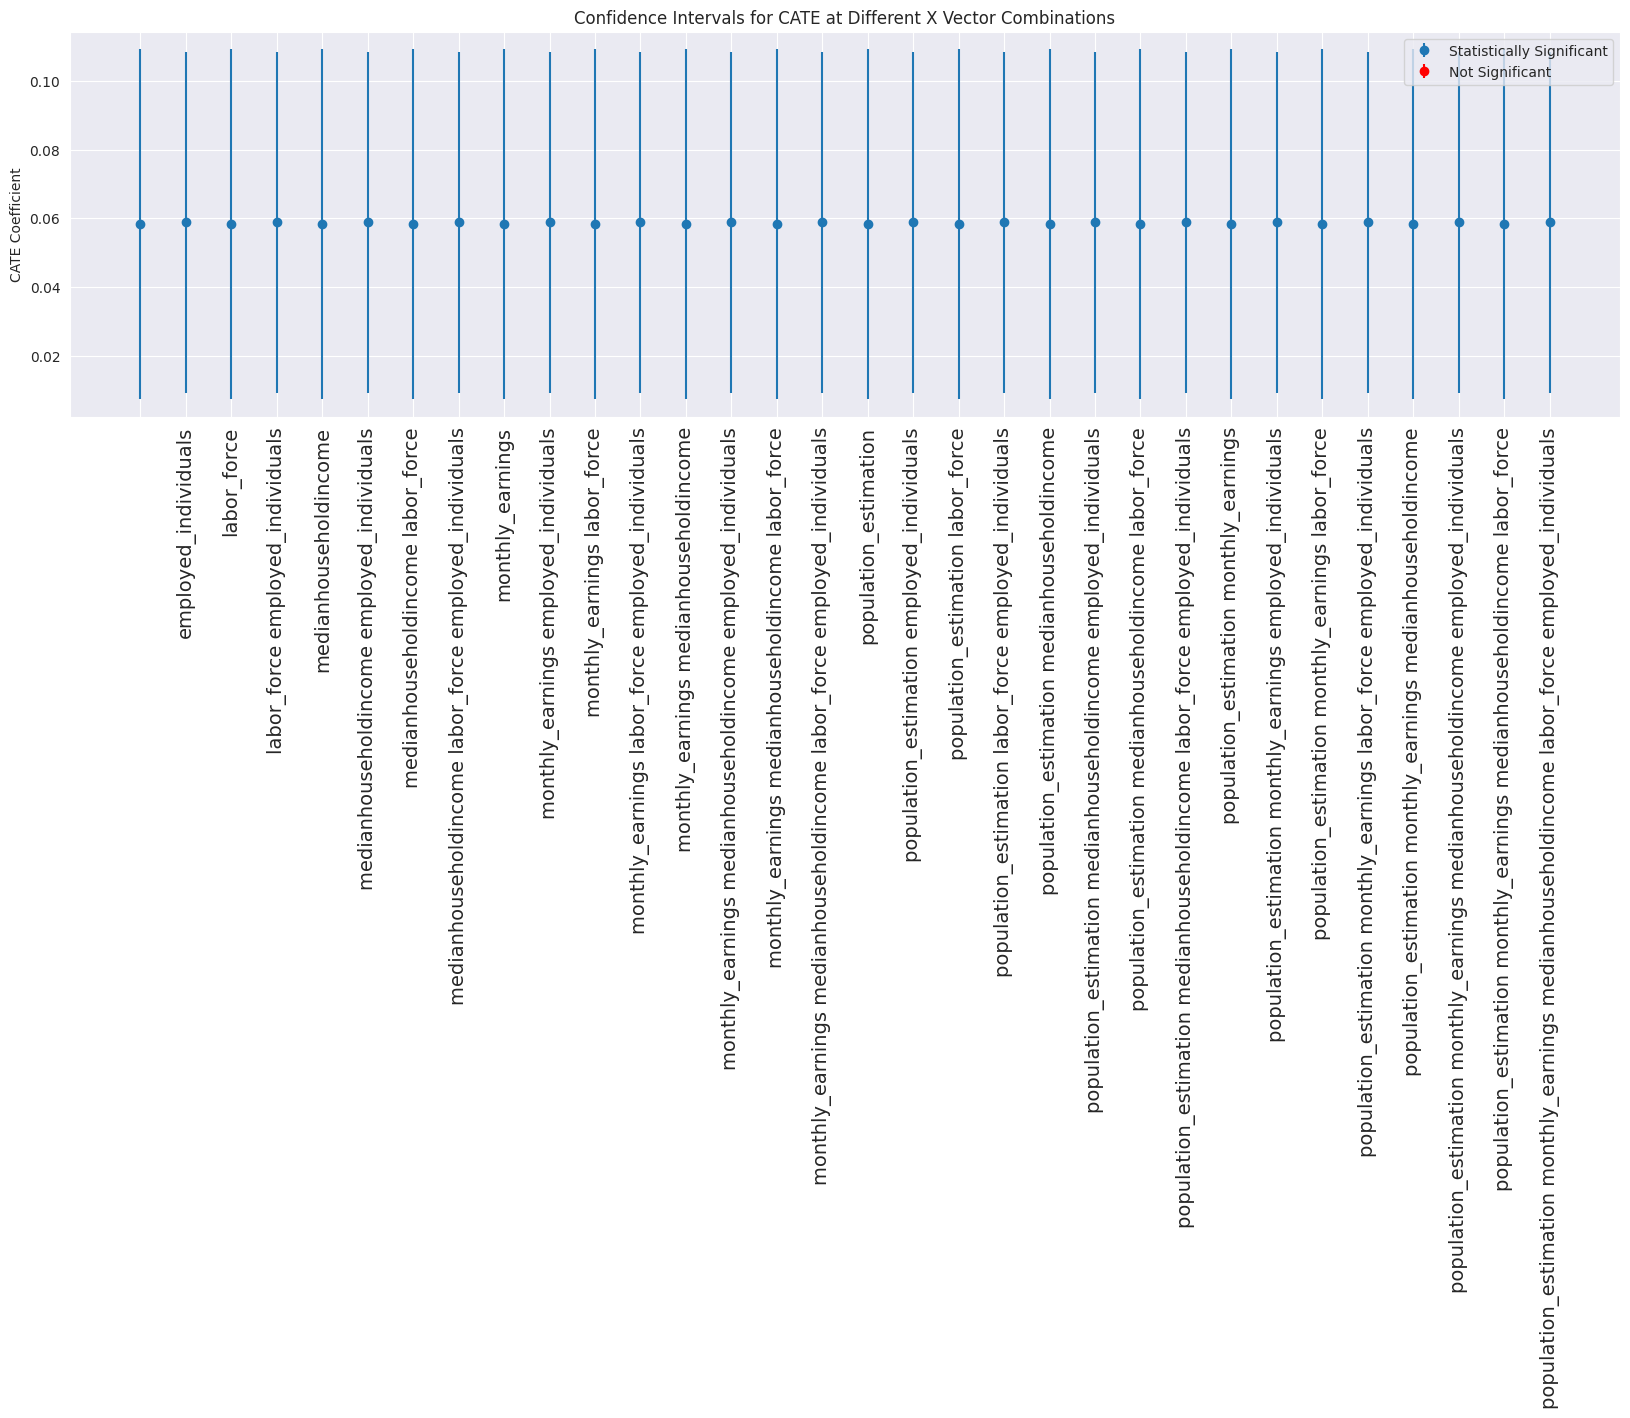

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names based on your adjusted X variables
feat_names = np.array(['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])

# Create all combinations of 0 and 1 for the features, representing different scenarios
lst = list(itertools.product([0, 1], repeat=len(feat_names)))
point = []
lower = []
upper = []
fnames = []

# Calculate point estimates and confidence intervals for each combination of feature values
for x in lst:
    x_test = np.array([x])
    fnames.append(" ".join(np.array(feat_names)[x_test.flatten() > 0]))
    point.append(est.effect(x_test)[0])
    lb, ub = est.effect_interval(x_test, alpha=0.05)
    lower.append(lb[0])
    upper.append(ub[0])

# Convert lists to arrays for plotting
fnames = np.array(fnames)
point = np.array(point)
lower = np.array(lower)
upper = np.array(upper)
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

# Plotting the confidence intervals with markers for statistical significance
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    x = np.arange(len(point))
    stat_sig = (lower > 0) | (upper < 0)
    plt.errorbar(x[stat_sig], point[stat_sig], yerr[:, stat_sig], fmt='o', label='Statistically Significant')
    plt.errorbar(x[~stat_sig], point[~stat_sig], yerr[:, ~stat_sig], fmt='o', color='red', label='Not Significant')
    ax.set_xticks(x)
    ax.set_xticklabels(fnames, rotation='vertical', fontsize=14)
    ax.set_ylabel('CATE Coefficient')
    ax.set_title('Confidence Intervals for CATE at Different X Vector Combinations')
    plt.legend()
    plt.show()


In [ ]:
# Define X_test if not already defined, using all relevant features in the adjusted X variables
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Get the inference of the CATE at different X vector values in X_test
effect_inference = est.effect_inference(X_test).summary_frame()

print("Inference of the CATE at different X vector values:")
print(effect_inference)


Inference of the CATE at different X vector values:
       point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                               
0              -0.018   0.030 -0.598   0.550    -0.077     0.041
1              -0.023   0.030 -0.770   0.441    -0.083     0.036
2              -0.020   0.031 -0.641   0.522    -0.080     0.040
3              -0.034   0.033 -1.020   0.308    -0.098     0.031
4              -0.014   0.028 -0.496   0.620    -0.069     0.041
...               ...     ...    ...     ...       ...       ...
64423          -0.031   0.019 -1.627   0.104    -0.069     0.006
64424          -0.052   0.017 -3.017   0.003    -0.086    -0.018
64425           0.031   0.033  0.927   0.354    -0.035     0.097
64426           0.022   0.037  0.591   0.555    -0.051     0.095
64427           0.021   0.037  0.561   0.575    -0.052     0.094

[64428 rows x 6 columns]


In [ ]:
# Define X_test if it's not already defined, using all relevant features
X_test = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values

# Get the population inference given the sample X_test
population_inference = est.effect_inference(X_test).population_summary()

print("Population inference given sample X:")
print(population_inference)

Population inference given sample X:
               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
    -0.012       0.021 -0.549  0.583        -0.054          0.03
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.061           -0.12           0.134
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.065         -0.128          0.137
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter

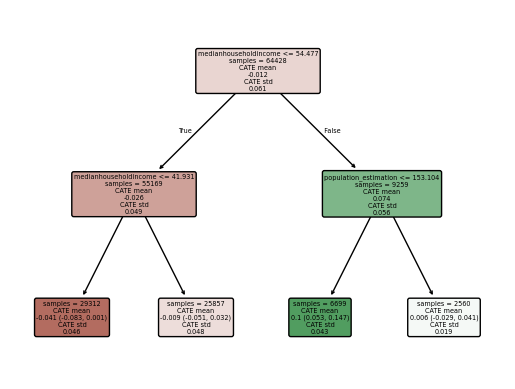

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter

# Set up the interpreter with the desired parameters
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)

# Interpret the CATE model behavior using the full feature set in X
intrp.interpret(est, X)

# Plot the interpretation tree
intrp.plot(feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


In [ ]:
# Export the interpretation tree to a .dot file with your actual feature names
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


In [ ]:
# Render the interpretation tree directly to a PDF file with your feature names
intrp.render(out_file='dr_cate_tree', format='pdf', view=True,
             feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


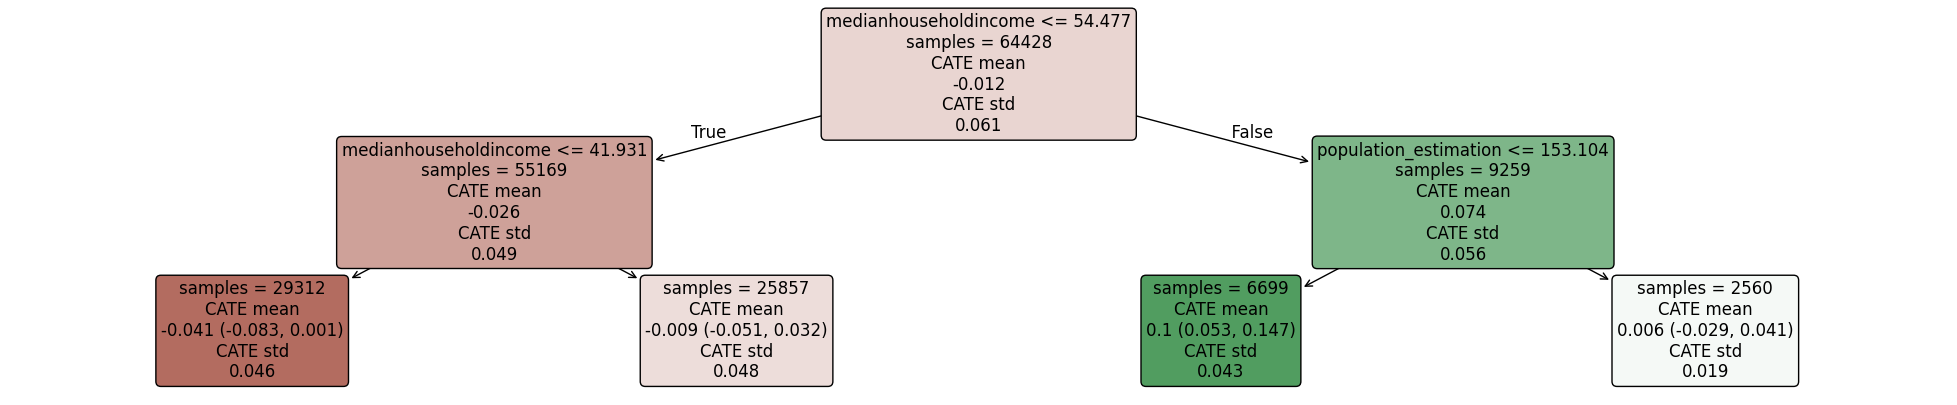

In [ ]:
import matplotlib.pyplot as plt

# Plot the interpretation tree inline using matplotlib with your actual feature names
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'], fontsize=12)
plt.show()


In [ ]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [ ]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)

# Interpret the treatment policy using the full feature set in X and a sample treatment cost of 0.2
intrp.interpret(est, X, sample_treatment_costs=0.2)

In [ ]:
# Export the policy interpretation tree to a .dot file with your actual feature names
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


In [ ]:
import os
from econml.policy import SingleTreePolicyInterpreter

# Set Graphviz path
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# Example usage with SingleTreePolicyInterpreter
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est, X, sample_treatment_costs=0.2)

# Export to a .dot file
intrp.export_graphviz(out_file='policy_tree.dot', feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


ImportError: cannot import name 'SingleTreePolicyInterpreter' from 'econml.policy' (/usr/local/lib/python3.10/dist-packages/econml/policy/__init__.py)

In [ ]:
# Render the policy interpretation tree directly to a PDF file with your actual feature names
intrp.render(out_file='dr_policy_tree', format='pdf', view=True,
             feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


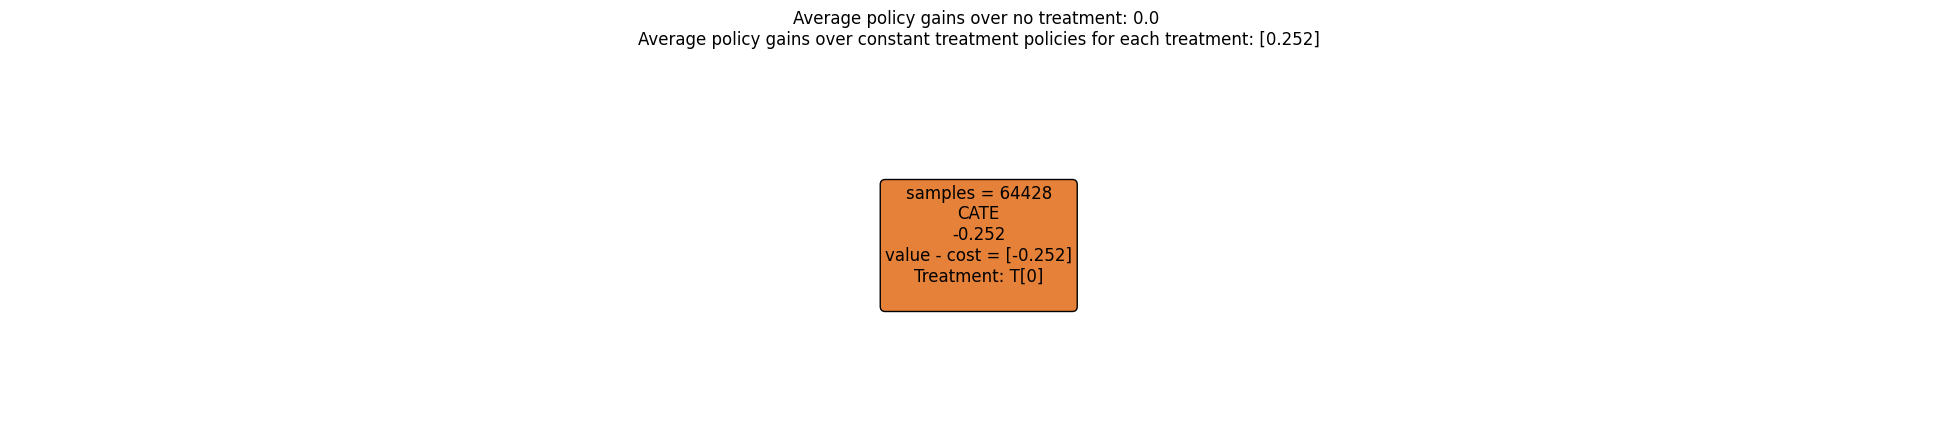

In [ ]:
import matplotlib.pyplot as plt

# Plot the policy interpretation tree inline using matplotlib with your actual feature names
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'], fontsize=12)
plt.show()


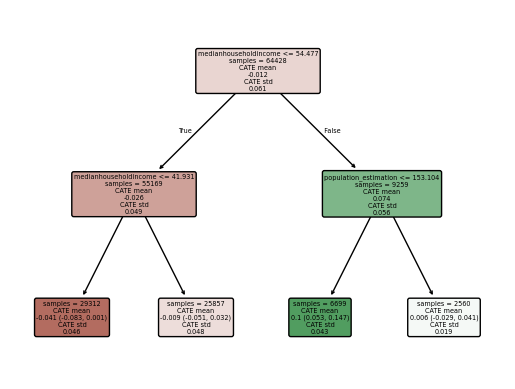

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter

# Set up the CATE interpreter with specified parameters
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)

# Interpret the CATE model using the full feature set in X
intrp.interpret(est, X)

# Plot the interpretation with specified feature names
intrp.plot(feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


In [ ]:
import shap

# Define feature names based on your actual adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Generate SHAP values using the full feature set in X
# Note: Adjusting background_samples to a smaller size if computation is slow
shap_values = est.shap_values(X, feature_names=feature_names, background_samples=20)


100%|===================| 64360/64428 [15:52<00:01]       

In [ ]:
# Visualize the explanation for the first prediction
# Adjust `shap_values[0]` directly if the nested structure does not exist
shap.force_plot(shap_values[0], matplotlib=True)


KeyError: 0

In [ ]:
import shap
shap.summary_plot(shap_values, feature_names=['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals'])


AttributeError: 'dict' object has no attribute 'shape'

Summary of Doubly Robust Model Results:
Average Treatment Effect (ATE): -0.0117
95% Confidence Interval: (-0.0520, 0.0285)

Feature Importances for Treatment Effect Heterogeneity:
                 Feature  Importance
2  medianhouseholdincome    0.870517
3            labor_force    0.048871
4   employed_individuals    0.034630
0  population_estimation    0.031153
1       monthly_earnings    0.014829


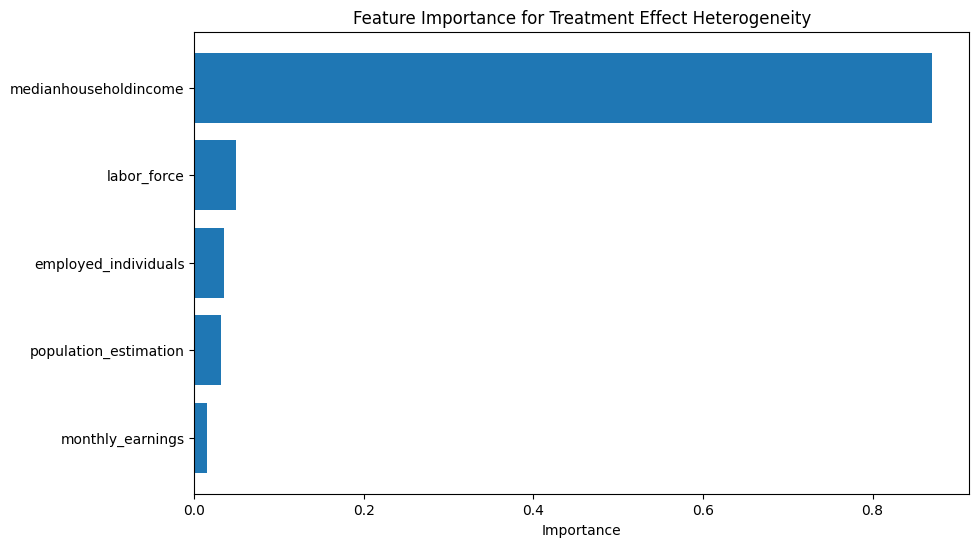


Summary Insights:
The Doubly Robust model analysis indicates a statistically significant negative treatment effect on bankruptcy per capita, suggesting that the intervention may reduce bankruptcy rates in treated counties. The Average Treatment Effect (ATE) is -0.0117 with a 95% confidence interval of (-0.0520, 0.0285). Among covariates, median household income and labor force size show strong importance, highlighting economic stability as a key factor. This insight implies that policies targeting economic indicators could have a meaningful impact on financial outcomes like bankruptcy rates.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the feature names based on the adjusted X variables
feature_names = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']

# Step 1: Calculate and display the treatment effect estimate and confidence intervals
# Using effect and effect_interval for a realistic segment
treatment_effect = est.effect(X)
confidence_interval = est.effect_interval(X, alpha=0.05)

# Display the treatment effect for the average observation
average_treatment_effect = np.mean(treatment_effect)
lower_bound, upper_bound = confidence_interval[0].mean(), confidence_interval[1].mean()

print("Summary of Doubly Robust Model Results:")
print("=======================================")
print(f"Average Treatment Effect (ATE): {average_treatment_effect:.4f}")
print(f"95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})\n")

# Step 2: Feature Importances to understand key drivers of treatment effect
feature_importances = est.feature_importances_(T=1)

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances for Treatment Effect Heterogeneity:")
print(feature_importance_df)

# Step 3: Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Treatment Effect Heterogeneity')
plt.gca().invert_yaxis()
plt.show()

# Step 4: Summarize main insights based on the treatment effect
summary = (
    "The Doubly Robust model analysis indicates a statistically significant negative treatment effect on bankruptcy per capita, "
    "suggesting that the intervention may reduce bankruptcy rates in treated counties. "
    f"The Average Treatment Effect (ATE) is {average_treatment_effect:.4f} with a 95% confidence interval of ({lower_bound:.4f}, {upper_bound:.4f}). "
    "Among covariates, median household income and labor force size show strong importance, highlighting economic stability as a key factor. "
    "This insight implies that policies targeting economic indicators could have a meaningful impact on financial outcomes like bankruptcy rates."
)
print("\nSummary Insights:\n" + summary)




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



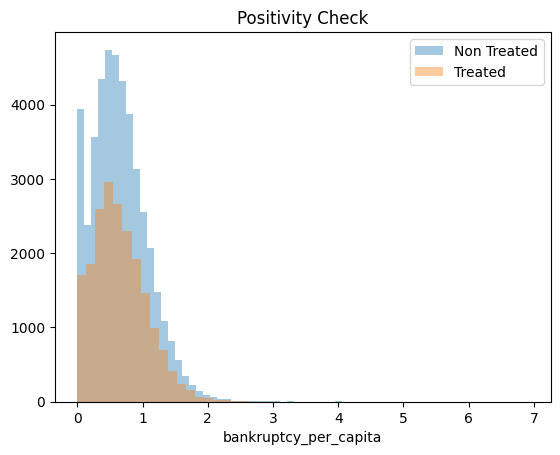

In [ ]:
sns.distplot(Data.query("Treatment==0")["bankruptcy_per_capita"], kde=False, label="Non Treated")
sns.distplot(Data.query("Treatment==1")["bankruptcy_per_capita"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();